<a href="https://colab.research.google.com/github/PacktPublishing/Modern-Computer-Vision-with-PyTorch-2E/blob/main/Chapter04/Cats_Vs_Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from PIL import Image
from torch import optim
from torchvision import datasets, models, transforms

device = "cuda" if torch.cuda.is_available() else "cpu"
import glob

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline
from glob import glob

In [2]:
%pip install -q kaggle

/root/Desktop/vision/Modern-Computer-Vision-with-PyTorch-2E/.venv/bin/python: No module named pip
Note: you may need to restart the kernel to use updated packages.


Visit the file [Obtaining kaggle.json.pdf](https://github.com/PacktPublishing/Modern-Computer-Vision-with-PyTorch-2E/blob/main/Chapter04/Obtaining%20kaggle.json.pdf) on how to download `kaggle.json` file

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kishorea","key":"f0bd77235bde8d9f794645060af5cc95"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [5]:
!kaggle datasets download -d tongpython/cat-and-dog

Dataset URL: https://www.kaggle.com/datasets/tongpython/cat-and-dog
License(s): CC0-1.0


In [6]:
!ls

 all.zip
 cat-and-dog.zip
 Cats_Vs_Dogs.ipynb
'CNN from scratch in Python.pdf'
 CNN_on_FashionMNIST.ipynb
 CNN_working_details.ipynb
 Data_augmentation_with_CNN.ipynb
 Image_augmentation.ipynb
'Implementing data augmentation.pdf'
 Issues_with_image_translation.ipynb
 kaggle.json
'Obtaining kaggle.json.pdf'
 Time_comparison_of_augmentation_scenario.ipynb
"Visualizing_the_filters'_learning.ipynb"


In [7]:
!unzip cat-and-dog.zip

Archive:  cat-and-dog.zip
  inflating: test_set/test_set/cats/_DS_Store  
  inflating: test_set/test_set/cats/cat.4001.jpg  
  inflating: test_set/test_set/cats/cat.4002.jpg  
  inflating: test_set/test_set/cats/cat.4003.jpg  
  inflating: test_set/test_set/cats/cat.4004.jpg  
  inflating: test_set/test_set/cats/cat.4005.jpg  
  inflating: test_set/test_set/cats/cat.4006.jpg  
  inflating: test_set/test_set/cats/cat.4007.jpg  
  inflating: test_set/test_set/cats/cat.4008.jpg  
  inflating: test_set/test_set/cats/cat.4009.jpg  
  inflating: test_set/test_set/cats/cat.4010.jpg  
  inflating: test_set/test_set/cats/cat.4011.jpg  
  inflating: test_set/test_set/cats/cat.4012.jpg  
  inflating: test_set/test_set/cats/cat.4013.jpg  
  inflating: test_set/test_set/cats/cat.4014.jpg  
  inflating: test_set/test_set/cats/cat.4015.jpg  
  inflating: test_set/test_set/cats/cat.4016.jpg  
  inflating: test_set/test_set/cats/cat.4017.jpg  
  inflating: test_set/test_set/cats/cat.4018.jpg  
  inflat

In [ ]:
train_data_dir = "./training_set/training_set"
test_data_dir = "./test_set/test_set"

In [9]:
from torch.utils.data import DataLoader, Dataset


class cats_dogs(Dataset):
    def __init__(self, folder):
        cats = glob(folder + "/cats/*.jpg")
        dogs = glob(folder + "/dogs/*.jpg")
        self.fpaths = cats + dogs
        from random import shuffle, seed

        seed(10)
        shuffle(self.fpaths)
        self.targets = [
            fpath.split("/")[-1].startswith("dog") for fpath in self.fpaths
        ]  # dog=1 & cat=0

    def __len__(self):
        return len(self.fpaths)

    def __getitem__(self, ix):
        f = self.fpaths[ix]
        target = self.targets[ix]
        im = cv2.imread(f)[:, :, ::-1]
        im = cv2.resize(im, (224, 224))
        return torch.tensor(im / 255).permute(2, 0, 1).to(device).float(), torch.tensor(
            [target]
        ).float().to(device)

In [10]:
data = cats_dogs(train_data_dir)
im, label = data[200]

In [11]:
len(data)

8005

tensor([1.], device='cuda:0')


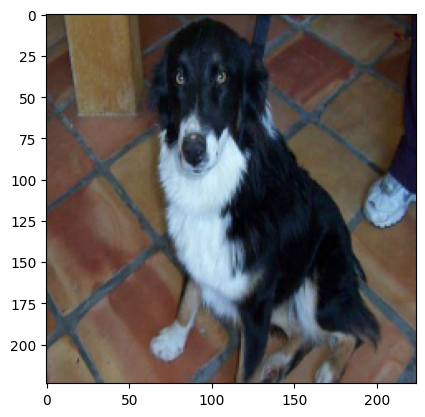

In [12]:
plt.imshow(im.permute(1, 2, 0).cpu())
print(label)

In [13]:
def conv_layer(ni, no, kernel_size, stride=1):
    return nn.Sequential(
        nn.Conv2d(ni, no, kernel_size, stride),
        nn.ReLU(),
        nn.BatchNorm2d(no),
        nn.MaxPool2d(2),
    )


def get_model():
    model = nn.Sequential(
        conv_layer(3, 64, 3),
        conv_layer(64, 512, 3),
        conv_layer(512, 512, 3),
        conv_layer(512, 512, 3),
        conv_layer(512, 512, 3),
        conv_layer(512, 512, 3),
        nn.Flatten(),
        nn.Linear(512, 1),
        nn.Sigmoid(),
    ).to(device)
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

In [14]:
from torchsummary import summary

model, loss_fn, optimizer = get_model()
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 222, 222]           1,792
              ReLU-2         [-1, 64, 222, 222]               0
       BatchNorm2d-3         [-1, 64, 222, 222]             128
         MaxPool2d-4         [-1, 64, 111, 111]               0
            Conv2d-5        [-1, 512, 109, 109]         295,424
              ReLU-6        [-1, 512, 109, 109]               0
       BatchNorm2d-7        [-1, 512, 109, 109]           1,024
         MaxPool2d-8          [-1, 512, 54, 54]               0
            Conv2d-9          [-1, 512, 52, 52]       2,359,808
             ReLU-10          [-1, 512, 52, 52]               0
      BatchNorm2d-11          [-1, 512, 52, 52]           1,024
        MaxPool2d-12          [-1, 512, 26, 26]               0
           Conv2d-13          [-1, 512, 24, 24]       2,359,808
             ReLU-14          [-1, 512,

In [15]:
def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    opt.step()
    opt.zero_grad()
    return batch_loss.item()


@torch.no_grad()
def accuracy(x, y, model):
    prediction = model(x)
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()

In [16]:
def get_data():
    train = cats_dogs(train_data_dir)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True, drop_last=True)
    val = cats_dogs(test_data_dir)
    val_dl = DataLoader(val, batch_size=32, shuffle=True, drop_last=True)
    return trn_dl, val_dl

In [17]:
@torch.no_grad()
def val_loss(x, y, model):
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [18]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [19]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []
    for ix, batch in enumerate(iter(trn_dl)):
        # print(ix)
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
        # validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    # val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4


In [20]:
len(train_epoch_accuracies)

8000

In [21]:
len(train_epoch_accuracies[0])

1

/tmp/ipykernel_1196653/3549289882.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(["{:.0f}%".format(x * 100) for x in plt.gca().get_yticks()])


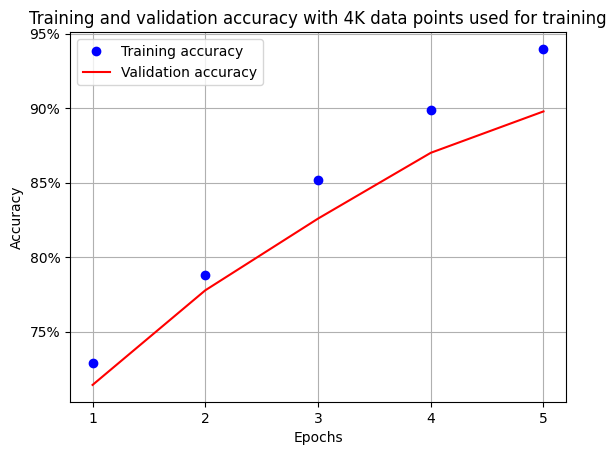

In [22]:
epochs = np.arange(5) + 1
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.ticker as mticker

%matplotlib inline
plt.plot(epochs, train_accuracies, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracies, "r", label="Validation accuracy")
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title("Training and validation accuracy with 4K data points used for training")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
# plt.ylim(0.8,1)
plt.gca().set_yticklabels(["{:.0f}%".format(x * 100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid("off")
plt.show()

In [23]:
from torch.utils.data import DataLoader, Dataset


class cats_dogs(Dataset):
    def __init__(self, folder):
        cats = glob(folder + "/cats/*.jpg")
        dogs = glob(folder + "/dogs/*.jpg")
        self.fpaths = cats[:500] + dogs[:500]
        from random import shuffle, seed

        seed(10)
        shuffle(self.fpaths)
        self.targets = [
            fpath.split("/")[-1].startswith("dog") for fpath in self.fpaths
        ]  # dog=1 & cat=0

    def __len__(self):
        return len(self.fpaths)

    def __getitem__(self, ix):
        f = self.fpaths[ix]
        target = self.targets[ix]
        im = cv2.imread(f)[:, :, ::-1]
        im = cv2.resize(im, (224, 224))
        return torch.tensor(im / 255).permute(2, 0, 1).to(device).float(), torch.tensor(
            [target]
        ).float().to(device)

In [24]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [25]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies_1k = [], []
for epoch in range(5):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []
    for ix, batch in enumerate(iter(trn_dl)):
        # print(ix)
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
        # validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    # val_losses.append(validation_loss)
    val_accuracies_1k.append(val_epoch_accuracy)

0
1
2
3
4


/tmp/ipykernel_1196653/2667065573.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(["{:.0f}%".format(x * 100) for x in plt.gca().get_yticks()])


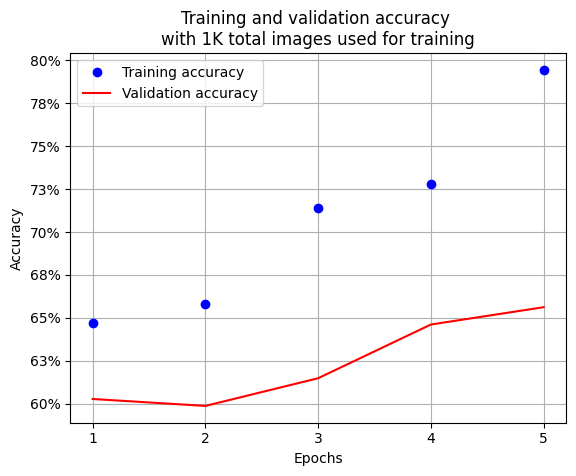

In [26]:
epochs = np.arange(5) + 1
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.ticker as mticker

%matplotlib inline

plt.plot(epochs, train_accuracies, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracies_1k, "r", label="Validation accuracy")
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title("Training and validation accuracy \nwith 1K total images used for training")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
# plt.ylim(0.8,1)
plt.gca().set_yticklabels(["{:.0f}%".format(x * 100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid("off")
plt.show()

In [ ]:
from torch.utils.data import DataLoader, Dataset


class cats_dogs(Dataset):
    def __init__(self, folder):
        cats = glob(folder + "/cats/*.jpg")
        dogs = glob(folder + "/dogs/*.jpg")
        self.fpaths = cats[:1000] + dogs[:1000]
        from random import shuffle, seed

        seed(10)
        shuffle(self.fpaths)
        self.targets = [
            fpath.split("/")[-1].startswith("dog") for fpath in self.fpaths
        ]  # dog=1 & cat=0

    def __len__(self):
        return len(self.fpaths)

    def __getitem__(self, ix):
        f = self.fpaths[ix]
        target = self.targets[ix]
        im = cv2.imread(f)[:, :, ::-1]
        im = cv2.resize(im, (224, 224))
        return torch.tensor(im / 255).permute(2, 0, 1).to(device).float(), torch.tensor(
            [target]
        ).float().to(device)

In [ ]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [ ]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies_2k = [], []
for epoch in range(5):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []
    for ix, batch in enumerate(iter(trn_dl)):
        # print(ix)
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
        # validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    # val_losses.append(validation_loss)
    val_accuracies_2k.append(val_epoch_accuracy)

0
1
2
3
4


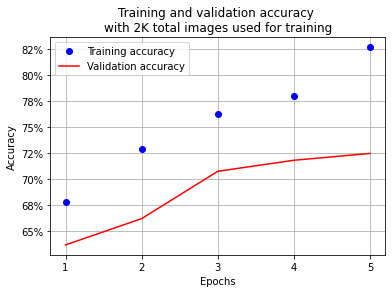

In [ ]:
epochs = np.arange(5) + 1
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.ticker as mticker

%matplotlib inline

plt.plot(epochs, train_accuracies, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracies_2k, "r", label="Validation accuracy")
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title("Training and validation accuracy \nwith 2K total images used for training")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
# plt.ylim(0.8,1)
plt.gca().set_yticklabels(["{:.0f}%".format(x * 100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid("off")
plt.show()

In [ ]:
from torch.utils.data import DataLoader, Dataset


class cats_dogs(Dataset):
    def __init__(self, folder):
        cats = glob(folder + "/cats/*.jpg")
        dogs = glob(folder + "/dogs/*.jpg")
        self.fpaths = cats[:2000] + dogs[:2000]
        from random import shuffle, seed

        seed(10)
        shuffle(self.fpaths)
        self.targets = [
            fpath.split("/")[-1].startswith("dog") for fpath in self.fpaths
        ]  # dog=1 & cat=0

    def __len__(self):
        return len(self.fpaths)

    def __getitem__(self, ix):
        f = self.fpaths[ix]
        target = self.targets[ix]
        im = cv2.imread(f)[:, :, ::-1]
        im = cv2.resize(im, (224, 224))
        return torch.tensor(im / 255).permute(2, 0, 1).to(device).float(), torch.tensor(
            [target]
        ).float().to(device)

In [ ]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [ ]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies_4k = [], []
for epoch in range(5):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []
    for ix, batch in enumerate(iter(trn_dl)):
        # print(ix)
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
        # validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    # val_losses.append(validation_loss)
    val_accuracies_4k.append(val_epoch_accuracy)

0
1
2
3
4


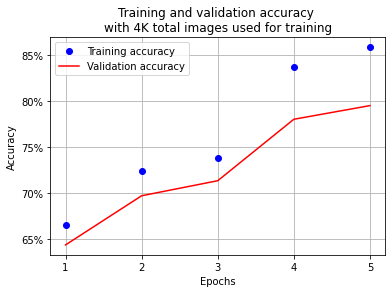

In [ ]:
epochs = np.arange(5) + 1
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.ticker as mticker

%matplotlib inline

plt.plot(epochs, train_accuracies, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracies_4k, "r", label="Validation accuracy")
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title("Training and validation accuracy \nwith 4K total images used for training")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
# plt.ylim(0.8,1)
plt.gca().set_yticklabels(["{:.0f}%".format(x * 100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid("off")
plt.show()

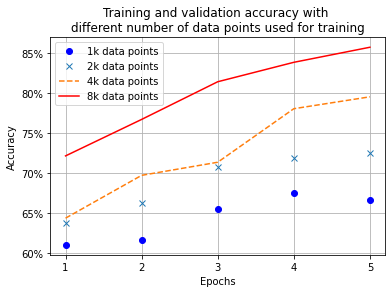

In [ ]:
epochs = np.arange(5) + 1
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.ticker as mticker

%matplotlib inline

plt.plot(epochs, val_accuracies_1k, "bo", label="1k data points")
plt.plot(epochs, val_accuracies_2k, "x", label="2k data points")
plt.plot(epochs, val_accuracies_4k, "--", label="4k data points", markersize=20)
plt.plot(epochs, val_accuracies, "r", label="8k data points")
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title(
    "Training and validation accuracy with \ndifferent number of data points used for training"
)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
# plt.ylim(0.8,1)
plt.gca().set_yticklabels(["{:.0f}%".format(x * 100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid("off")
plt.show()